In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# データセットの読み込み
ここでは、企業が従業員の離職を減少させるために人事部が離職要因の特定と各従業員の離職確率の予測精度向上を目標としているとする。

人事部の達成目標
 - 離職要因の特定
 - 各従業員の離職予測

In [6]:
HR_DATASET_PATH = "datasets/HR_comma_sep.csv"

hr_df = pd.read_csv(HR_DATASET_PATH)
print(hr_df.shape)
hr_df.head()

(14999, 10)


,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [6]:
hr_df.isnull().values.sum()

0

欠損している行はない。

In [7]:
hr_df.sales.unique()

array(['sales', 'accounting', 'hr', 'technical', 'support', 'management',
       'IT', 'product_mng', 'marketing', 'RandD'], dtype=object)

In [8]:
hr_df.salary.unique()

array(['low', 'medium', 'high'], dtype=object)

In [9]:
# salary(給与水準)をダミー変数へ置換する
hr_df.salary.replace({'low': 1, 'medium': 2, 'high': 3}, inplace=True)

---
# 混合正規分布(Gaussian mixture)によるクラスタリング

k-平均法では、クラスタリングの過程において各事例ベクトルはいずれかのクラスタに属している。しかし、二つのクラスタの中間付近にたまたま存在するような事例ベクトルがあるとしよう。本当はどっちつかずなのに、代表ベクトルからの微妙な距離の違いによってどちらかに分けられてしまう。これが問題になるかどうかはわからないが、**どちらかに分けてしまうのではなく、確率的に分けてみることを考えよう**。

> ex) あるベクトルは20%の確率でクラスタ1に属し、80%の確率でクラスタ2に属すとしよう。そして、クラスタ1の代表ベクトルを再計算するときは、このベクトルは20%ぶんだけ寄与し、またクラスタ2の代表ベクトルを計算するときは、80%ぶんだけ寄与することになる。

→「ベクトルを分ける」ステップが、ベクトルに各クラスタに属する確率を与えることになる

 - $x^{(i)}$: $d$次元ベクトル
 - $P\left({c}|{x^{(i)}}\right)$: クラスタの事後確率(posterior probability)

この事後確率にどのような確率値が与えられるかは、どのような確率分布を考えるか次第である。
 1. ここでは、$P\left({x}|{c}\right)$が正規分布であると仮定する。
 2. ただし、分散$\sigma^{2}$は既知であり、かつクラスタによって変わらないものとする。
 
 - $m_c$: クラスタcの平均ベクトル

事後確率を計算するために、ベイズ定理を用いるが尤度を
$$
P\left( { x^{ (i) } }|{ c } \right) =\frac { 1 }{ \sqrt { { \left( 2\pi \sigma ^{ 2 } \right)  }^{ d } }  } exp\left( -\cfrac { { \left| { x^{ (i) } }-{ m }_{ c } \right|  }^{ 2 } }{ 2\sigma ^{ 2 } }  \right) 
$$
と表す。すると、$P\left({c}|{x^{(i)}}\right)$はつぎのように計算できる:
$$
P\left({c}|{x^{(i)}}\right) = \frac {P\left(x^{(i)}, c\right)}{P\left(x^{(i)}\right)} = \frac {P\left(c, x^{(i)}\right)}{ \sum _{c}{ P\left(c, x^{(i)}\right) } } = \frac { P\left(c\right)P\left({x^{(i)}}|{c}\right) }{ \sum _{c}{ P\left(c\right)P\left({x^{(i)}}|{c}\right) } }\\
=\frac { P\left( c \right) exp\left( -\cfrac { { \left| { x^{ (i) } }-{ m }_{ c } \right|  }^{ 2 } }{ 2\sigma ^{ 2 } }  \right)  }{ \sum _{ c }{ P\left( c \right) exp\left( -\cfrac { { \left| { x^{ (i) } }-{ m }_{ c } \right|  }^{ 2 } }{ 2\sigma ^{ 2 } }  \right)  }  } 
$$
$x^{(i)}$の生起確率(周辺尤度)は複数の正規分布からなっており、**混合正規分布(Gaussian mixture)**とよばれる。

つぎに、「代表ベクトルを再計算する」ステップをみてみる。k-平均法では、
$$
m_{c} = \frac {1}{ \left| c \right| }\sum _{x^{(i)} \in c }{ x^{(i)} }\\
= \frac { \sum _{ x^{ (i) }\in D }{ \delta \left( { x }^{ (i) }\in c \right) { x }^{ (i) } }  }{ \sum _{ x^{ (i) }\in D }{ \delta \left( { x }^{ (i) }\in c \right)  }  } 
$$

 - $\delta \left(x^{(i)} \in c\right)$: ベクトル$x^{(i)}$がクラスタcに含まれているなら1、そうでなければ0をとる関数

と計算した。しかし、ここでは確率の重み付きで平均mを計算することになる。クラスタcの代表ベクトルを$m_{c}$で表せば、
$$
m_{ c }=\frac { \sum _{ x^{ (i) }\in D }{ P\left( { c }|{ x^{ (i) } } \right) { x }^{ (i) } }  }{ \sum _{ x^{ (i) }\in D }{ P\left( { c }|{ x^{ (i) } } \right)  }  }  \quad (3.6)
$$
と計算されることになる。つまり、ここでは各$x^{(i)}$は、そのクラスタへの事後確率$P\left( { c }|{ x^{ (i) } } \right) $ぶんだけこの計算に寄与することになる。


## 混合正規分布(Gaussian mixture)によるクラスタリングのアルゴリズム

 - ※$P\left(c\right)$は固定して考える
 
入力: 特徴ベクトル集合$\left\{ x^{(1)}, x^{(2)}, \cdots, x^{(\left|D\right|)} \right\}$<br>
: クラスタ数$k$

無作為に${m^{\prime}}_{1}, {m^{\prime}}_{2}, \cdots, {m^{\prime}}_{k}$を決定
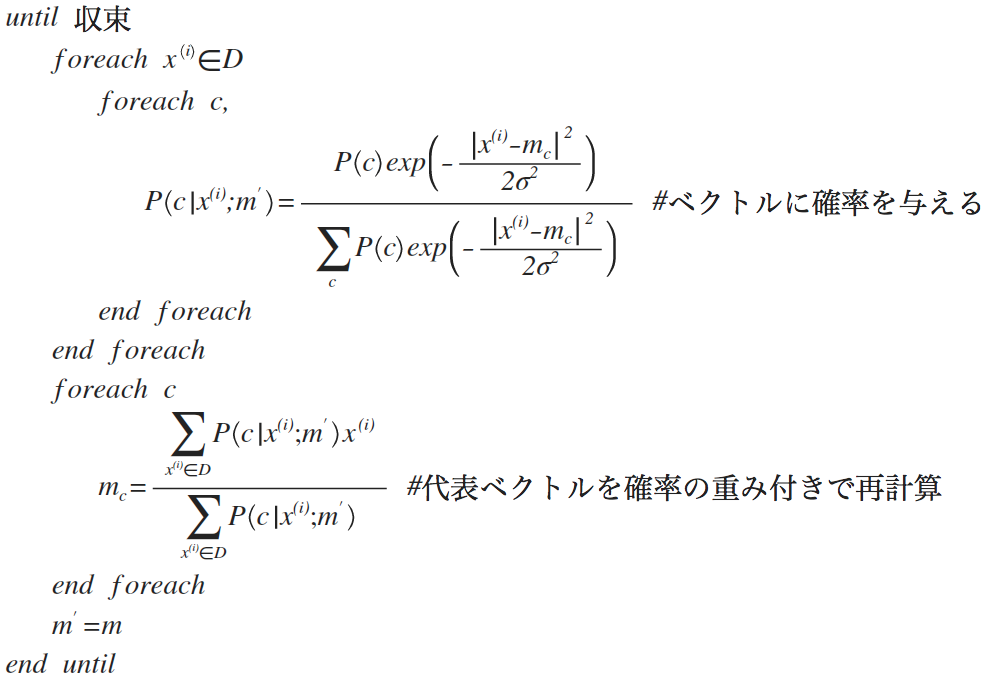

 - $\sigma^{2}$も未知の場合を扱うためには、代表ベクトル$m_{c}$の再計算に加え、$\sigma^{2}$も再計算することになる。
 - 混合正規分布によるクラスタリングでは、$P\left({c}|{x^{(i)}}\right)$の値は(コンピュータが扱える範囲で)微小に変化し続けるので収束判定が難しい。実用上は、例えばパラメータ値の変化(例えば、$\sum _{c}{{ {\left| m_{c} - {m^{\prime}}_{c} \right|}^{2} }}$)が非常に小さくなったら、収束したとみなすことができる。しかし、混合正規分布によるクラスタリングは、つぎに説明するEMアルゴリズムの一種であるので、EMアルゴリズムでの収束判定を用いるほうがよいだろう

# EMアルゴリズム(Expectation-Maximization algorithm)
混合正規分布によるクラスタリングは、じつは、ここで紹介するEMアルゴリズムという、より一般的な枠組みに基づいている。

混合正規分布によるクラスタリングでは、**平均(代表ベクトル)**の再計算を行った。
$$
m_{ c }=\frac { \sum _{ x^{ (i) }\in D }{ P\left( { c }|{ x^{ (i) } };{ m }^{ \prime  } \right) { x }^{ (i) } }  }{ \sum _{ x^{ (i) }\in D }{ P\left( { c }|{ x^{ (i) };{ m }^{ \prime  } } \right)  }  }
$$
この計算方法について考えてみる。もし、各特徴ベクトル$x^{(i)}$が属するクラスタがわかっていたとすると、対数尤度
$$
\log { \left( \theta  \right)  } =\sum _{ x^{ (i) }\in D }{ \log { P\left( c,x^{ (i) };\theta  \right)  }  } 
$$
を最大化することにより、パラメータ(平均)が計算できる。しかし、実際$c$は未知である。そのかわり、$P\left( { c }|{ x^{ (i) } };\theta  \right) $が計算されている(直前に計算されたパラメータ$\theta^{\prime}$で算出された確率値であることを明示している)。よって、すべての$c$の場合について確率を重みにして対数尤度を足し合わせることを考える。すなわち、$\log { P\left( c,x^{ (i) };\theta  \right)  }$を
$$
\sum _{ c }{ P\left( { c }|{ { x }^{ \left( i \right)  } };{ \theta  }^{ \prime  } \right) \log { P\left( c,{ x }^{ \left( i \right)  };\theta  \right)  }  } 
$$
にすげ替えるのである。結局、対数尤度$\sum _{ x^{ (i) }\in D }{ \log { P\left( c,x^{ (i) };\theta  \right)  }  } $の代わりに、EMアルゴリズムでは
$$
\sum _{ x^{ (i) }\in D }{ \sum _{ c }{ P\left( { c }|{ { x }^{ \left( i \right)  } };{ \theta  }^{ \prime  } \right) \log { P\left( c,{ x }^{ \left( i \right)  };\theta  \right)  }  }  } 
$$
を最大にするようなパラメータ$\theta$を繰り返しみつけていくことになる。

> <font color='red'>※</font>最大化する$\theta$をみつけるときは、$\theta^{\prime}$は定数であり、ひいては$ P\left( { c }|{ { x }^{ \left( i \right)  } };{ \theta  }^{ \prime  } \right)$も定数であることに注意したい。

この関数は、一般的に**Q関数(Q-function)**とよばれ、新しいパラメータ$\theta$と直前のパラメータ$\theta^{\prime}$を明示して$Q\left(\theta; \theta^{\prime}\right)$と表される。:
$$
Q\left(\theta; \theta^{\prime}\right) = \sum _{ x^{ (i) }\in D }{ \sum _{ c }{ P\left( { c }|{ { x }^{ \left( i \right)  } };{ \theta  }^{ \prime  } \right) \log { P\left( c,{ x }^{ \left( i \right)  };\theta  \right)  }  }  } \quad (3.7)
$$

## EMアルゴリズム
入力: **不完全データ$D$**<br>
$\theta$の初期値は無作為に決める
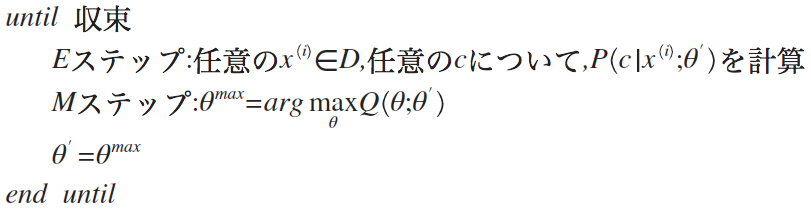

 - Eステップ: 各訓練ベクトルがそれぞれのクラスタcにどの程度属しているのかを計算。これにより、混合正規分布クラスタリングで各特徴ベクトルの確率$P\left({c}|{x}\right)$を計算したことに対応していることがわかるだろう。

 - このアルゴリズムによって、対数尤度$\sum _{x^{(i)} \in D}{ \log { \sum _{c}{P\left(c,x^{(i)}; \theta\right)} } }$は単調に増加していく。単調に増加しなかった場合はどこかに間違いがあるはずである。
 - 収束判定: 対数尤度$\sum _{x^{(i)} \in D}{ \log { \sum _{c}{P\left(c,x^{(i)}; \theta\right)} } }$の増加が非常に小さくなったら終了する、などの基準が使える。

## 混合正規分布によるクラスタリングの計算式の導出(EMアルゴリズムから)
### Eステップ: $P\left( { c }|{ x^{ (i) } };{ m }^{ \prime  } \right) $
Eステップは「混合正規分布(Gaussian mixture)によるクラスタリングのアルゴリズム」で明らかにしたように次式である。
$$
P\left( { c }|{ x^{ (i) } };{ m }^{ \prime  } \right) =\frac { P\left( c \right) exp\left( -\cfrac { { \left| { x^{ (i) } }-{ m }_{ c } \right|  }^{ 2 } }{ 2\sigma ^{ 2 } }  \right)  }{ \sum _{ c }{ P\left( c \right) exp\left( -\cfrac { { \left| { x^{ (i) } }-{ m }_{ c } \right|  }^{ 2 } }{ 2\sigma ^{ 2 } }  \right)  }  } 
$$

### Mステップ: ${ \theta  }^{ max }=arg\max _{ \theta  }{ Q\left( \theta ;{ \theta  }^{ \prime  } \right)  } $
#### 平均ベクトルの算出
Mステップが式(3.6)に対応することを証明する。Q関数は次のように表される。
$$
\max _{ \theta  }{ Q\left( \theta ;{ \theta  }^{ \prime  } \right)  } =\sum _{ { x }^{ \left( i \right)  }\in D }{ \sum _{ c }{ P\left( { c }|{ { x }^{ \left( i \right)  } };{ \theta  }^{ \prime  } \right)  } \log { P\left( c,{ x }^{ \left( i \right)  };\theta  \right)  }  } \\ \qquad \qquad \qquad =\sum _{ { x }^{ \left( i \right)  }\in D }{ \sum _{ c }{ P\left( { c }|{ { x }^{ \left( i \right)  } };{ \theta  }^{ \prime  } \right)  } \log { P\left( c \right) P\left( { { x }^{ \left( i \right)  } }|{ c } \right)  }  } \\ \qquad \qquad \qquad =\sum _{ { x }^{ \left( i \right)  }\in D }{ \sum _{ c }{ P\left( { c }|{ { x }^{ \left( i \right)  } };{ \theta  }^{ \prime  } \right)  } \log { P\left( c \right) \frac { 1 }{ \sqrt { { \left( 2\pi { \sigma  }^{ 2 } \right)  }^{ d } }  }  } exp\left( -\cfrac { { \left| { x }^{ \left( i \right)  }-{ m }_{ c } \right|  }^{ 2 } }{ 2{ \sigma  }^{ 2 } }  \right)  } \\ \qquad \qquad \qquad =\sum _{ { x }^{ \left( i \right)  }\in D }{ \sum _{ c }{ P\left( { c }|{ { x }^{ \left( i \right)  } };{ \theta  }^{ \prime  } \right)  } \left\{ \log { P\left( c \right) + } \log { \frac { 1 }{ \sqrt { { \left( 2\pi { \sigma  }^{ 2 } \right)  }^{ d } }  }  } -\cfrac { { \left| { x }^{ \left( i \right)  }-{ m }_{ c } \right|  }^{ 2 } }{ 2{ \sigma  }^{ 2 } }  \right\}  } 
$$
これを最大化する$m_{c}$を求めるために、$m_{c}$で微分してみると、($P\left( { c }|{ { x }^{ \left( i \right)  } };{ \theta  }^{ \prime  } \right) $が定数であることに注意して！)
$$
\frac { \partial Q\left( \theta ;\theta ^{ \prime  } \right)  }{ \partial m_{ c } } \equiv \left( \frac { \partial Q\left( \theta ;\theta ^{ \prime  } \right)  }{ \partial m_{ c1 } } ,\frac { \partial Q\left( \theta ;\theta ^{ \prime  } \right)  }{ \partial m_{ c2 } } ,\cdots  \right) =\sum _{ { x }^{ \left( i \right)  }\in D }{ P\left( { c }|{ { x }^{ \left( i \right)  } };{ \theta  }^{ \prime  } \right) \left\{ \frac { \left| { x }^{ \left( i \right)  }-{ m }_{ c } \right|  }{ { \sigma  }^{ 2 } }  \right\}  } =0
$$
となる。上式を展開すると式(3.6)が得られる。

※
>$$
\sum _{ { x }^{ \left( i \right)  }\in D }{ \sum _{ c }{ P\left( { c }|{ { x }^{ \left( i \right)  } };{ \theta  }^{ \prime  } \right)  } \left\{ \log { P\left( c \right) + } \log { \frac { 1 }{ \sqrt { { \left( 2\pi { \sigma  }^{ 2 } \right)  }^{ d } }  }  } -\cfrac { { \left| { x }^{ \left( i \right)  }-{ m }_{ c } \right|  }^{ 2 } }{ 2{ \sigma  }^{ 2 } }  \right\}  } \\ =\sum _{ { x }^{ \left( i \right)  }\in D }{ \left[ P\left( { { c }_{ 1 } }|{ { x }^{ \left( i \right)  } };{ \theta  }^{ \prime  } \right) \left\{ \log { P\left( { c }_{ 1 } \right) + } \log { \frac { 1 }{ \sqrt { { \left( 2\pi { \sigma  }^{ 2 } \right)  }^{ d } }  }  } -\cfrac { { \left| { x }^{ \left( i \right)  }-{ m }_{ c1 } \right|  }^{ 2 } }{ 2{ \sigma  }^{ 2 } }  \right\} +P\left( { { c }_{ 2 } }|{ { x }^{ \left( i \right)  } };{ \theta  }^{ \prime  } \right) \left\{ \log { P\left( { c }_{ 2 } \right) + } \log { \frac { 1 }{ \sqrt { { \left( 2\pi { \sigma  }^{ 2 } \right)  }^{ d } }  }  } -\cfrac { { \left| { x }^{ \left( i \right)  }-{ m }_{ c2 } \right|  }^{ 2 } }{ 2{ \sigma  }^{ 2 } }  \right\} +\cdots  \right]  } 
$$
>微分すると
>$$
\frac { \partial Q\left( \theta ;\theta ^{ \prime  } \right)  }{ \partial { m }_{ c1 } } =\sum _{ { x }^{ \left( i \right)  }\in D }{ \left[ P\left( { { c }_{ 1 } }|{ { x }^{ \left( i \right)  } };{ \theta  }^{ \prime  } \right) \left\{ \cfrac { { \left| { x }^{ \left( i \right)  }-{ m }_{ c1 } \right|  } }{ { \sigma  }^{ 2 } }  \right\}  \right]  } \\ \frac { \partial Q\left( \theta ;\theta ^{ \prime  } \right)  }{ \partial { m }_{ c2 } } =\sum _{ { x }^{ \left( i \right)  }\in D }{ \left[ P\left( { { c }_{ 2 } }|{ { x }^{ \left( i \right)  } };{ \theta  }^{ \prime  } \right) \left\{ \cfrac { { \left| { x }^{ \left( i \right)  }-{ m }_{ c2 } \right|  } }{ { \sigma  }^{ 2 } }  \right\}  \right]  } \\ \vdots 
$$
>となる。よって、
> $$
\frac { \partial Q\left( \theta ;\theta ^{ \prime  } \right)  }{ \partial m_{ c } } \equiv \left( \frac { \partial Q\left( \theta ;\theta ^{ \prime  } \right)  }{ \partial m_{ c1 } } ,\frac { \partial Q\left( \theta ;\theta ^{ \prime  } \right)  }{ \partial m_{ c2 } } ,\cdots  \right) =\sum _{ { x }^{ \left( i \right)  }\in D }{ P\left( { c }|{ { x }^{ \left( i \right)  } };{ \theta  }^{ \prime  } \right) \left\{ \frac { \left| { x }^{ \left( i \right)  }-{ m }_{ c } \right|  }{ { \sigma  }^{ 2 } }  \right\}  } 
 $$

#### 分散の算出
[分散の導出](http://kujira16.hateblo.jp/entry/2015/12/06/223951)

#### $P\left(c\right)$の算出
$\sum _{c}{P\left(c\right)} = 1$という制約があるので、ラグランジュ関数
$$
L = Q\left(\theta; \theta^{\prime}\right) +\lambda \left( 1 - \sum _{c}{P\left(c\right)} \right)\\
=\sum _{ { x }^{ \left( i \right)  }\in D }{ \sum _{ c }{ P\left( { c }|{ { x }^{ \left( i \right)  } };{ \theta  }^{ \prime  } \right)  } \left\{ \log { P\left( c \right) + } \log { \frac { 1 }{ \sqrt { { \left( 2\pi { \sigma  }^{ 2 } \right)  }^{ d } }  }  } -\cfrac { { \left| { x }^{ \left( i \right)  }-{ m }_{ c } \right|  }^{ 2 } }{ 2{ \sigma  }^{ 2 } }  \right\}  } +\lambda \left[ 1-\sum _{ c }{ P\left( c \right)  }  \right] 
$$
を微分して0とおけば、
$$
\frac { \partial L }{ \partial P\left( c \right)  } =\sum _{ x^{ (i) }\in D }{ P\left( { c }|{ x^{ (i) };\theta  } \right)  } \frac { 1 }{ P\left( c \right)  } +\lambda =0\\ P\left( c \right) =-\frac { 1 }{ \lambda  } \sum _{ x^{ (i) }\in D }{ P\left( { c }|{ x^{ (i) };\theta  } \right)  } 
$$
となる。また、
$$
\frac { \partial L }{ \partial \lambda  } =1-\sum _{ c }{ P\left( c \right)  } =0
$$
※$P\left( c \right) =\frac { 1 }{ \lambda  } \sum _{ x^{ (i) }\in D }{ P\left( { c }|{ x^{ (i) };\theta  } \right)  }  $より
$$
-\frac { 1 }{ \lambda  } \sum _{ c }{ \sum _{ x^{ (i) }\in D }{ P\left( { c }|{ x^{ (i) };\theta  } \right)  }  } =1
$$
が成り立つので、
$$
P\left( c \right) =\frac { \sum _{ x^{ (i) }\in D }{ P\left( { c }|{ x^{ (i) };\theta  } \right)  }  }{ \sum _{ c }{ \sum _{ x^{ (i) }\in D }{ P\left( { c }|{ x^{ (i) };\theta  } \right)  }  }  } =\frac { \sum _{ x^{ (i) }\in D }{ P\left( { c }|{ x^{ (i) };\theta  } \right)  }  }{ \left| D \right|  } 
$$
上式の第２式の分母は次のように書き換えられる。
$$
\sum _{ x^{ (i) }\in D }{ \sum _{ c }{ P\left( { c }|{ x^{ (i) };\theta  } \right)  }  } =\sum _{ x^{ (i) }\in D }{ 1 } =\left| D \right| 
$$

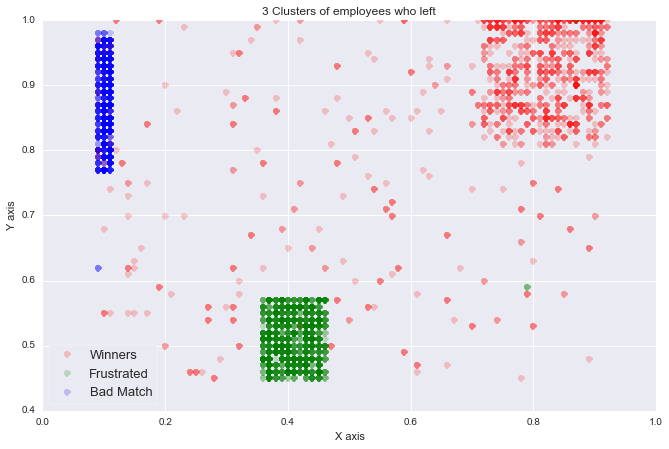

In [68]:
from matplotlib.colors import LogNorm
from sklearn.mixture import GaussianMixture

X = left_employee_df.drop(['left', 'sales'], axis=1)

# 混合正規分布によるクラスタリング
# http://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html
# http://qh73xebitbucketorg.readthedocs.io/ja/latest/1.Programmings/python/LIB/scikit-learn/GaussianMixtureModels/main/
gmm = GaussianMixture(n_components=3, covariance_type='full', random_state=0)
gmm.fit(X)

preds = gmm.predict(X)
X['pred'] = preds

# scater method → http://pythondatascience.plavox.info/matplotlib/%E6%95%A3%E5%B8%83%E5%9B%B3
plt.figure(figsize=(11,7))
plt.xlabel('X axis')
plt.ylabel('Y axis')
plt.title('3 Clusters of employees who left')

plt.plot(X.satisfaction_level[X.pred==0], X.last_evaluation[X.pred==0],'o', alpha = 0.2, color = 'r')
plt.plot(X.satisfaction_level[X.pred==1], X.last_evaluation[X.pred==1],'o', alpha = 0.2, color = 'g')
plt.plot(X.satisfaction_level[X.pred==2],X.last_evaluation[X.pred==2],'o', alpha = 0.2, color = 'b')
plt.legend(['Winners','Frustrated','Bad Match'], loc = 'best', fontsize = 13, frameon=True)


plt.show()